In [26]:
import os
import re
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
BASE_PATH = "../results/all_limitless/baati"

def readAppData(path, skiprows=28):
    df = pd.read_csv(path, skiprows=skiprows, parse_dates=True)
    df["datetime"] = pd.to_datetime(df["time_h"])
    return df
    
def readResData(path):
    res = pd.read_csv(path)
    res["datetime"] = pd.to_datetime(res["time"], utc=True)
    return res
    
def readExp(expid, base_path=BASE_PATH, node="baati"):
    data_path = glob.glob(os.path.join(base_path, expid, f"VM_runtime_app_*.csv"))[0]
    res_path = glob.glob(os.path.join(base_path, expid, f"resources/metric_node_*_cpu.csv"))[0]
    return readAppData(data_path), readResData(res_path)


def dfInterval(df, tmin, tmax):
    return (tmin <= df["datetime"]) & (df["datetime"] <= tmax)

def getSplitIntervals(df):
    ais = df["ai_name"].unique()
    tss = [df.loc[df["ai_name"] == ai, "datetime"].min() for ai in ais]
    tss.append(df["datetime"].max())
    tss.sort()
    return list(zip(tss[:-1], tss[1:]))

def splitDF(df, timestampDF=None, ai_name="ai_1"):
    if timestampDF is None:
        timestampDF = df
    tss = getSplitIntervals(timestampDF)
    if ai_name is not None:
        df = df[df["ai_name"] == ai_name]
    return [df[dfInterval(df, *ts)] for ts in tss]


def getMetrics(dfs, metric_name="app_latency"):
    metric = np.array([df2[metric_name].mean() for df2 in dfs])
    stddev = np.array([df2[metric_name].std() for df2 in dfs])
    return metric, stddev

def plotPerf(df, expid, metric_name="app_latency"):
    dfs = splitDF(df)
    fig, ax = plt.subplots()
    metric, metric_stddev = getMetrics(dfs)
    ax.errorbar(range(1, len(metric)+1), metric, yerr=metric_stddev)
    ax.set_ylabel(metric_name)
    ax.set_title(expid)
    plt.show()
    
def plotRegressionLine(ax, x, y, yerr, b, expid=None, metric_name="app_latency"): 
    x = np.array(x)
    ax.errorbar(x, y,yerr, color = "m", fmt="o") 
    #plt.scatter(x, y, color = "m", yerr=yerr, 
    #           marker = "o", s = 30) 
    y_pred = b[0] + b[1]*x 
    ax.plot(x, y_pred, color = "g") 
    #plt.show()
    
def getXs(ys):
    return list(range(1, len(ys)+1))

def fitRegression(ys):
    xs2 = [[i] for i in getXs(ys)]
    reg = linear_model.LinearRegression()
    reg.fit(xs2, ys)
    return np.array([reg.intercept_, reg.coef_[0]])

# expid, t1, t2, ai_name, tasks, avg_latency, avg_throughput, std_latency, std_throughput, latency_samples_count
def analizeData(expid, ax, base_path=BASE_PATH, metric_name="app_latency", rescale=False, silent=False):
    print(expid)
    df, res = readExp(expid, base_path=base_path)
    dfs = splitDF(df)
    ys, yerr = getMetrics(dfs, metric_name)
    if rescale:
        factor = ys[0]
        ys /= factor
        yerr /= factor
    coef = fitRegression(ys)
    if not silent:
        plotRegressionLine(ax, getXs(ys), ys, yerr, coef, expid, metric_name)
        #print (f"Coef: {coef}")
        #df[metric_name].plot()
        #plt.show()
        #res["value"].plot()
    return coef


def getCpuSinglePod(expid, role, ts, base_path=BASE_PATH, ai="ai-1"):
    tmin, tmax = ts
    path = glob.glob(os.path.join(base_path, expid, f"resources/metric_pod_*{role}-{ai}*_cpu.csv"))[0]
    res = readResData(path)
    return res.loc[(tmin < res["datetime"]) & (res["datetime"] < tmax), ["datetime", "value"]]

def getCpuLimits(ai_type_role, factor=2.):
    def getExpid(ai_type):
        if ai_type == "redis_ycsb":
            ai_type = "redis"
        return f"{ai_type}_1"
    result = []
    for ai_type, roles in ai_type_role.items():
        expid = getExpid(ai_type)
        print(expid)
        df, _ = readExp(expid)
        tmax = df.loc[df["ai_name"] == "ai_2", "datetime"].min()
        tmin = df.loc[df["ai_name"] == "ai_1", "datetime"].min()
        ts = (tmin, tmax)
        for role in roles:
            res = getCpuSinglePod(expid, role, ts)
            limit = int(res["value"].mean() * factor)
            result.append((ai_type, role, limit))
    return result


def detectExpid(t1, t2, base_path=BASE_PATH, select_fn=max):
    expid = t1 if t1 == t2 else f"{t1}_{t2}"
    def matchExpidRegex(e):
        expid_regex = "[0-9]{0,4}" + expid
        i = e.split("/")[-1]
        return bool(re.fullmatch(expid_regex, i))
    
    pattern = os.path.join(base_path, f"*{expid}")
    expids = glob.glob(pattern)
    expids = [e for e in expids if matchExpidRegex(e)]
    #print(f"there are {len(expids)} results after filtering")
    if not expids:
        raise ValueError(f"Not found any experiment for types {t1} {t2} and glob pattern {pattern}")
    return select_fn(expids)

In [2]:
paths = glob.glob("data/1*")
for path in paths: 
    expid_splitted = path.split("/")
    if len(expid_splitted) < 2:
        print(f"skipping path {path}")
        continue
    expid = expid_splitted[1]
    print(f"Checking {expid}")
    df, _ = readExp(expid, base_path="data")
    print(f"{expid}: {len(df['ai_name'].unique())}")


Checking 106wrk
106wrk: 15
Checking 107wrk_linpack
107wrk_linpack: 15
Checking 105wrk_redis_ycsb
105wrk_redis_ycsb: 15
Checking 104redis_ycsb_hadoop
104redis_ycsb_hadoop: 15
Checking 108wrk_hadoop
108wrk_hadoop: 6
Checking 100redis_ycsb
100redis_ycsb: 14
Checking 115hadoop_linpack
115hadoop_linpack: 6
Checking 110linpack_wrk
110linpack_wrk: 14
Checking 116hadoop
116hadoop: 6
Checking 111linpack
111linpack: 15
Checking 103redis_ycsb_linpack
103redis_ycsb_linpack: 15
Checking 101redis_ycsb
101redis_ycsb: 15
Checking 112linpack_hadoop
112linpack_hadoop: 6
Checking 109linpack_redis_ycsb
109linpack_redis_ycsb: 15
Checking 102redis_ycsb_wrk
102redis_ycsb_wrk: 15
Checking 113hadoop_redis_ycsb
113hadoop_redis_ycsb: 15
Checking 114hadoop_wrk
114hadoop_wrk: 6


In [2]:
def getExpid(t1, t2):
    return f"{t1}_{t2}_1" if t1 != t2 else f"{t1}_1"

def shortTypeToLong(t1):
    return "redis_ycsb" if t1 == "redis" else t1

#TODO fix naming of experiments
ai_type_role = dict()
ai_type_role["redis"] = ["ycsb", "redis"]
ai_type_role["hadoop"] = ["hadoopmaster", "hadoopslave"]
ai_type_role["linpack"] = ["linpack"]
ai_type_role["wrk"] = ["wrk", "apache"]

t1 = "redis"
t2s = ["redis", "wrk", "hadoop", "linpack"]
n = len(t2s)

def toSingleRowDF(d):
    d2 = {}
    for k, v in d.items():
        d2.update({k: pd.Series(v, index=[0])})
    return pd.DataFrame(d2)

# DF: expid, t1, t2, ai_no, ai_role, tasks, avg_cpu, std_cpu, cpu_samples_count
def getResourceDatapoint(t1, t2, ai_no, ai_role, tasks, ts, res):
    res = res.loc[dfInterval(res, *ts), ["datetime", "value"]]
    res = res["value"]
    d = {"expid": getExpid(t1, t2), "t1": t1, "t2": t2, "ai_no": ai_no+1}
    d.update({"ai_role": ai_role, "tasks": tasks+1})
    d.update({"avg_cpu": res.mean(), "std_cpu": res.std(), "cpu_samples_count": res.count()})
    return toSingleRowDF(d)

def getResourceDatapointsRole(t1, t2, ai_no, ai_role, tss):
    expid = getExpid(t1, t2)
    exp_dir = os.path.join(BASE_PATH, expid)
    results = pd.DataFrame()
    try:
        path = glob.glob(os.path.join(exp_dir, f"resources/metric_pod_*{ai_role}-ai-{ai_no+1}*_cpu.csv"))[0]
    except IndexError as err:
        raise ValueError(f"No resource record in directory {exp_dir} for ai_role \
            {ai_role} and ai no. {ai_no+1}") from None
    res = readResData(path)
    for tasks in range(ai_no, len(tss)):
        result = getResourceDatapoint(t1, t2, ai_no, ai_role, tasks, tss[tasks], res)
        results = results.append(result, ignore_index=True)
    return results
            

def getResourceDatapoints(t1, t2, ai_nr, tss):
    results = pd.DataFrame()
    t = t1 if not ai_nr else t2
    for ai_role in ai_type_role[t]:
        result = getResourceDatapointsRole(t1, t2, ai_nr, ai_role, tss)
        results = results.append(result, ignore_index=True)
    return results


# select expid, tasks, sum cpu
# expid -> {tasks{1,..,6}: sum_cpu}
# join with expid, tasks, performance

resources = pd.DataFrame()
results = pd.DataFrame()
for t1 in t2s:
    for t2 in t2s:
        expid = getExpid(t1, t2)
        df, _ = readExp(expid)
        tss = getSplitIntervals(df)
        max_ais = len(tss)
        for ai_no in range(max_ais):
            result = getResourceDatapoints(t1, t2, ai_no, tss)
            results = results.append(result, ignore_index=True)
print(results)
results.info()
res = results
    

         expid       t1       t2  ai_no  ai_role  tasks      avg_cpu  \
0      redis_1    redis    redis      1     ycsb      1  1185.285714   
1      redis_1    redis    redis      1     ycsb      2  1171.500000   
2      redis_1    redis    redis      1     ycsb      3  1127.952381   
3      redis_1    redis    redis      1     ycsb      4  1071.095238   
4      redis_1    redis    redis      1     ycsb      5   997.190476   
..         ...      ...      ...    ...      ...    ...          ...   
539  linpack_1  linpack  linpack      4  linpack      5  1542.000000   
540  linpack_1  linpack  linpack      4  linpack      6  1364.650000   
541  linpack_1  linpack  linpack      5  linpack      5  1509.571429   
542  linpack_1  linpack  linpack      5  linpack      6  1437.850000   
543  linpack_1  linpack  linpack      6  linpack      6  1433.100000   

        std_cpu  cpu_samples_count  
0     23.413976                 21  
1     23.166446                 20  
2     28.909300         

In [131]:
res.info()
cpu_sum = res.groupby(["expid", "t1", "t2", "tasks"], as_index=False).sum()
cpu_sum.pop("ai_no")
cpu_sum

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   expid              544 non-null    object 
 1   t1                 544 non-null    object 
 2   t2                 544 non-null    object 
 3   ai_no              544 non-null    int64  
 4   ai_role            544 non-null    object 
 5   tasks              544 non-null    int64  
 6   avg_cpu            544 non-null    float64
 7   std_cpu            544 non-null    float64
 8   cpu_samples_count  544 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 38.4+ KB


,expid,t1,t2,tasks,avg_cpu,std_cpu,cpu_samples_count
0,hadoop_1,hadoop,hadoop,1,1775.991342,918.808308,43
1,hadoop_1,hadoop,hadoop,2,3583.863636,2210.529938,88
2,hadoop_1,hadoop,hadoop,3,4823.909091,3372.699732,132
3,hadoop_1,hadoop,hadoop,4,6415.368421,4560.201658,152
4,hadoop_linpack_1,hadoop,linpack,1,1186.444444,985.378715,18
...,...,...,...,...,...,...,...
87,wrk_redis_1,wrk,redis,2,3493.190476,116.813905,84
88,wrk_redis_1,wrk,redis,3,4630.904762,172.521711,126
89,wrk_redis_1,wrk,redis,4,5566.038095,271.080041,166
90,wrk_redis_1,wrk,redis,5,6333.480736,304.995478,211


In [46]:
def getMetricsTmp(expid, metric_name="app_latency"):
    df = readExp(expid)
    dfs = splitDF(df)
    ys, yerr = getMetrics(dfs, metric_name)
    
    
def getPerformanceData(expids):
    results = pd.DataFrame()
    for expid in expids:
        df, _ = readExp(expid)
        df["expid"] = expid
        results = results.append(df, ignore_index=True)
    return results

tasks = ["redis", "wrk", "hadoop", "linpack"]
expids = [getExpid(t1, t2) for t1 in tasks for t2 in tasks]
perf_df = getPerformanceData(expids)
perf_df.info()

        
# parse all csvs
# avg metric per

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44578 entries, 0 to 44577
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   time                 44578 non-null  int64              
 1   time_h               44578 non-null  object             
 2   time_cbtool          44578 non-null  int64              
 3   time_cbtool_h        44578 non-null  object             
 4   uuid                 44578 non-null  object             
 5   name                 44578 non-null  object             
 6   role                 44578 non-null  object             
 7   ai_name              44578 non-null  object             
 8   type                 44578 non-null  object             
 9   host_name            44578 non-null  object             
 10  aidrs_name           44578 non-null  object             
 11  sla_provisioning     0 non-null      float64            
 12  app_load_id       

In [96]:
def splitDF(df, timestampDF=None, ai_name="ai_1"):
    if timestampDF is None:
        timestampDF = df
    tss = getSplitIntervals(timestampDF)
    if ai_name is not None:
        df = df[df["ai_name"] == ai_name]
    return [df[dfInterval(df, *ts)] for ts in tss]

# expid, t1, t2, ai_name, tasks
def aggregatePerf(input_df, rescale=True):
    results = pd.DataFrame()
    for expid in input_df["expid"].unique():
        df = input_df[input_df["expid"] == expid]
        tss = getSplitIntervals(df)
        ai_count = len(tss)
        for ai_no in range(ai_count):
            for tasks in range(ai_no, ai_count):
                ai_name = f"ai_{ai_no+1}"
                local_df = df[dfInterval(df, *tss[tasks]) & (df["ai_name"] == ai_name)]
                d = {"expid": expid, "ai_no": ai_no+1, "tasks": tasks+1}
                for metric in ["app_latency", "app_throughput"]:
                    if np.any(pd.isna(local_df[metric])):
                        continue
                    perf = local_df[metric]
                    m = metric[len("app_"):]
                    d.update({f"avg_{m}": perf.mean(), f"std_{m}": perf.std()})
                    d.update({f"{m}_samples_count": perf.count()})
                results = results.append(toSingleRowDF(d), ignore_index=True)
    return results
                
perf = aggregatePerf(perf_df)

In [134]:
expid = "redis_1"
#df.info()
#print(getCpuLimits(ai_type_role))

joined = cpu_sum.merge(perf, on=["expid", "tasks"])
#join expid, tasks, for ai_no
joined["expid"].unique()

array(['hadoop_1', 'hadoop_linpack_1', 'hadoop_redis_1', 'hadoop_wrk_1',
       'linpack_1', 'linpack_hadoop_1', 'linpack_redis_1',
       'linpack_wrk_1', 'redis_1', 'redis_hadoop_1', 'redis_linpack_1',
       'redis_wrk_1', 'wrk_1', 'wrk_hadoop_1', 'wrk_linpack_1',
       'wrk_redis_1'], dtype=object)

/home/pawel/.virtualenvs/cbtool/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/pawel/.virtualenvs/cbtool/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


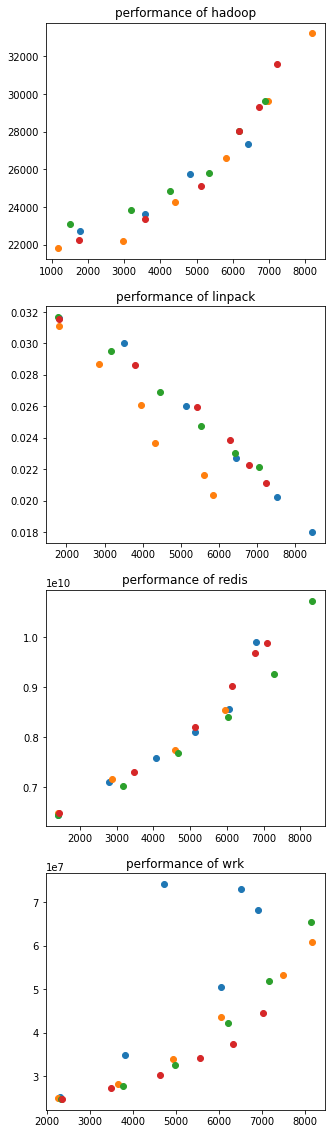

In [146]:
def printPerfVsCpu(input_df, rescale=True):
    t1s = input_df["t1"].unique()
    fig, axs = plt.subplots(len(t1s), 1, figsize=(5, 20))
    if len(t1s) == 1:
        axs = [axs]
        
    for i, t1 in enumerate(t1s):
        metric = "throughput" if t1 == "linpack" else "latency"
        avg_metric = f"avg_{metric}"
        std_metric = f"avg_{metric}"
        axs[i].set_title(f"performance of {t1}")
        df = input_df[(input_df["t1"] == t1) & (input_df["ai_no"] == 1)]
        if rescale:
            factor = df.loc[(df["tasks"] == 1), avg_metric].mean()
            df[avg_metric] /= factor
            df[std_metric] /= factor
        for t2 in df["t2"].unique():
            df2 = df[df["t2"] == t2]
            axs[i].scatter(df2["avg_cpu"], df2[avg_metric], label=t2)
        
printPerfVsCpu(joined)
plt.show()

there are 4 results after filtering
there are 1 results after filtering
there are 1 results after filtering
there are 1 results after filtering
there are 1 results after filtering
there are 1 results after filtering
there are 1 results after filtering
there are 1 results after filtering
there are 3 results after filtering
there are 1 results after filtering
there are 3 results after filtering
there are 1 results after filtering
there are 1 results after filtering
there are 1 results after filtering
there are 1 results after filtering
there are 1 results after filtering
../results/all_limitless/baati/1redis_ycsb
../results/all_limitless/baati/1redis_ycsb_wrk
../results/all_limitless/baati/1redis_ycsb_hadoop
../results/all_limitless/baati/1redis_ycsb_linpack
../results/all_limitless/baati/1wrk_redis_ycsb
../results/all_limitless/baati/1wrk
../results/all_limitless/baati/1wrk_hadoop
../results/all_limitless/baati/1wrk_linpack
../results/all_limitless/baati/1hadoop_redis_ycsb
../results/al

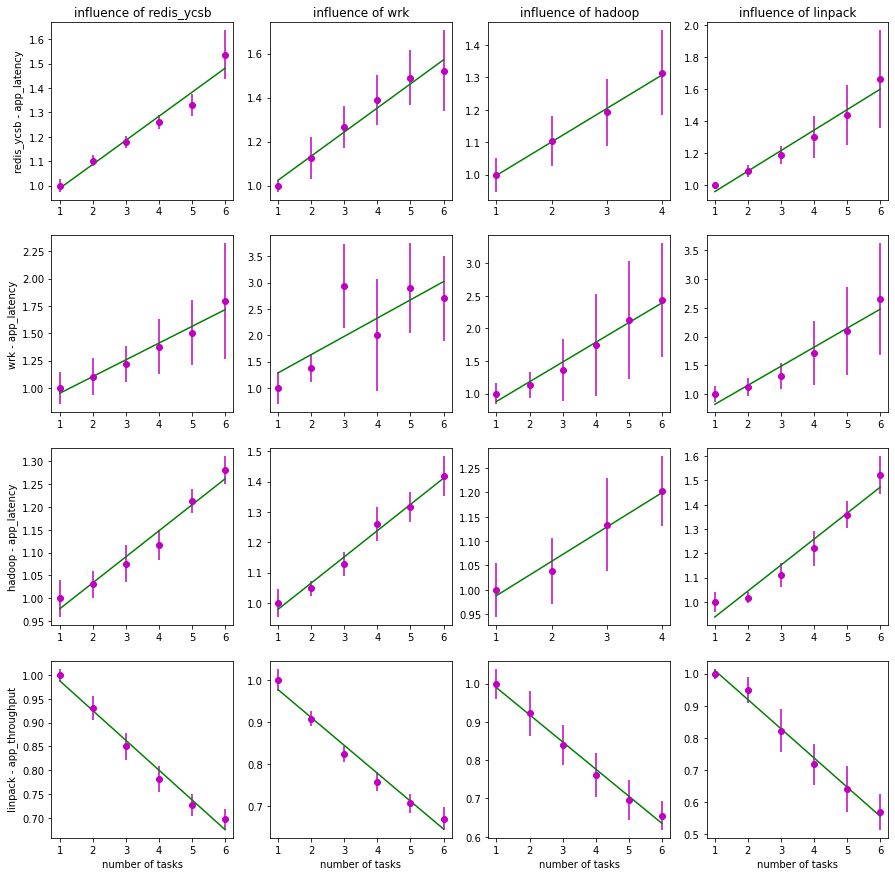

[[0.09850463 0.10939086 0.10299651 0.12770357]
 [0.15296261 0.34636941 0.30279389 0.33084764]
 [0.05699619 0.08645344 0.07038867 0.10692214]
 [0.06254286 0.06645851 0.0709298  0.09099933]]


In [17]:
"""
# TODO print cost function
"""
tasks = ["redis_ycsb", "wrk", "hadoop", "linpack"]
def analyzeInterferenceGrid(tasks, base_path=BASE_PATH, rescale=True, silent=False):
    results = []
    n = len(tasks)
    def getExpRecord(t1, t2):
        result = {}
        result["expid"] = detectExpid(t1, t2, base_path)
        result["t1"] = t1
        result["t2"] = t2
        result["metric"] = "app_throughput" if t1 == "linpack" else "app_latency"
        result["sign"] = -1. if result["metric"] == "app_throughput" else 1.
        return result
    def formatLegend(ax, exp, i, j):
        if j == n-1:
            ax.set_xlabel('number of tasks') 
        if not j:
            ax.set_title(f"influence of {exp['t2']}")
        if not i:
            ax.set_ylabel(f"{exp['t1']} - {exp['metric']}") 
    exps = [getExpRecord(t1, t2) for t1 in tasks for t2 in tasks]
    fig, axes = plt.subplots(n, n, figsize=(15., 15.))
    for i, exp,  in enumerate(exps):
        j, k = int(i / n), int(i % n)
        ax = axes[j, k]
        formatLegend(ax, exp, k, j)
        coefs = analizeData(exp["expid"], ax, base_path="", metric_name=exp["metric"], \
                            rescale=rescale, silent=silent)
        results.append(coefs[1] * exp["sign"])
    plt.show()
    results = np.array(results)
    results.resize([n, n])
    return np.array(results)

interference = analyzeInterferenceGrid(tasks)
print(interference)

data/101redis_ycsb
data/102redis_ycsb_wrk
data/104redis_ycsb_hadoop
data/103redis_ycsb_linpack
data/106wrk
data/108wrk_hadoop
data/107wrk_linpack
data/114hadoop_wrk
data/116hadoop
data/115hadoop_linpack
data/109linpack_redis_ycsb
data/118linpack_wrk
data/112linpack_hadoop
data/111linpack


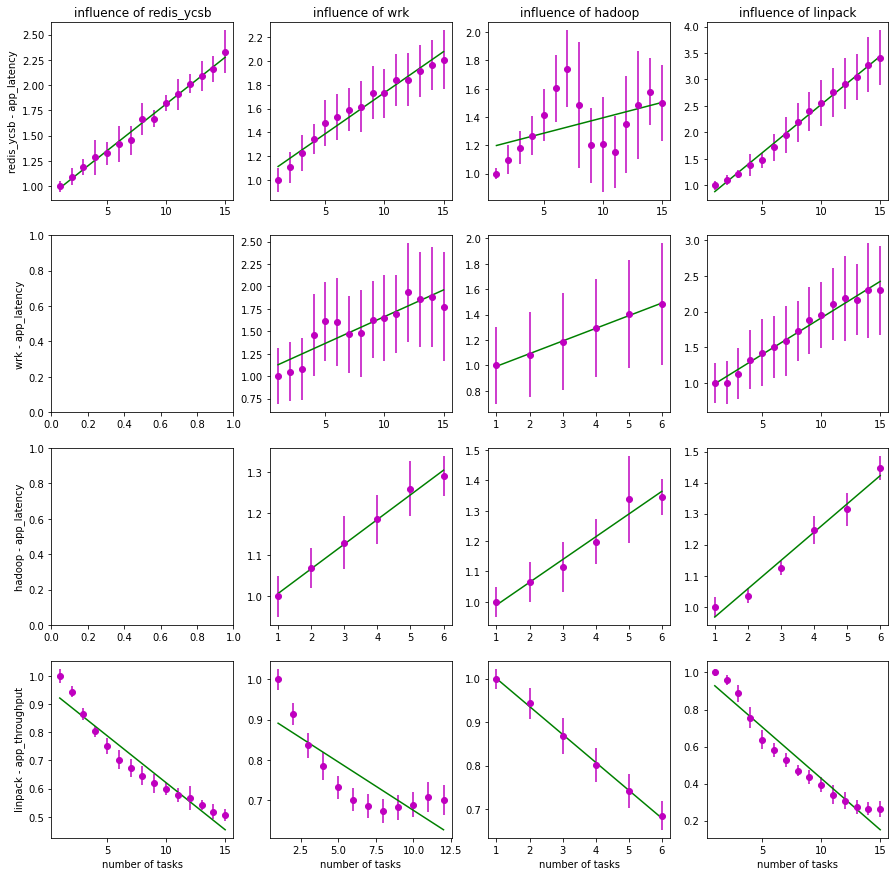

[[0.09251838 0.06896643 0.02174157 0.18303585]
 [0.         0.05950165 0.0996998  0.10239049]
 [0.         0.05943509 0.07495003 0.0910561 ]
 [0.03340253 0.02394899 0.06426189 0.05550344]]


In [28]:
def analyzeInterferenceGrid(tasks, skip_tasks=[], base_path=BASE_PATH, rescale=True, silent=False):
    results = []
    n = len(tasks)
    def getExpRecord(t1, t2):
        result = {}
        result["expid"] = detectExpid(t1, t2, base_path)
        result["t1"] = t1
        result["t2"] = t2
        result["metric"] = "app_throughput" if t1 == "linpack" else "app_latency"
        result["sign"] = -1. if result["metric"] == "app_throughput" else 1.
        return result
    def formatLegend(ax, exp, i, j):
        if j == n-1:
            ax.set_xlabel('number of tasks') 
        if not j:
            ax.set_title(f"influence of {exp['t2']}")
        if not i:
            ax.set_ylabel(f"{exp['t1']} - {exp['metric']}") 
    exps = [getExpRecord(t1, t2) for t1 in tasks for t2 in tasks]
    fig, axes = plt.subplots(n, n, figsize=(15., 15.))
    for i, exp,  in enumerate(exps):
        j, k = int(i / n), int(i % n)
        ax = axes[j, k]
        formatLegend(ax, exp, k, j)
        if (exp["t1"], exp["t2"]) in skip_tasks:
            results.append(0.)
        else:
            coefs = analizeData(exp["expid"], ax, base_path="", metric_name=exp["metric"], \
                                rescale=rescale, silent=silent)
            results.append(coefs[1] * exp["sign"])
    plt.show()
    results = np.array(results)
    results.resize([n, n])
    return np.array(results)
skip_tasks = [("wrk", "redis_ycsb"), ("hadoop", "redis_ycsb")]
interference = analyzeInterferenceGrid(tasks, skip_tasks=skip_tasks, base_path="data")
print(interference)

data/110linpack_wrk
data/118linpack_wrk


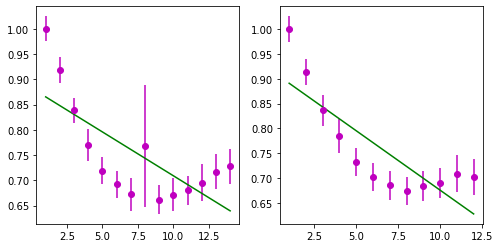

In [31]:
t1 = "linpack"
t2 = "wrk"
def getExpRecord(t1, t2, base_path, select_fn):
    result = {}
    result["expid"] = detectExpid(t1, t2, base_path=base_path, select_fn=select_fn)
    result["t1"] = t1
    result["t2"] = t2
    result["metric"] = "app_throughput" if t1 == "linpack" else "app_latency"
    result["sign"] = -1. if result["metric"] == "app_throughput" else 1.
    return result

exps = [getExpRecord(t1, t2, base_path="data", select_fn=f) for f in [min, max]]
fig, axs = plt.subplots(1, 2, figsize=(8., 4.))
for i, exp in enumerate(exps):
    ax = axs[i]
    coefs = analizeData(exp["expid"], ax, base_path="", metric_name=exp["metric"], \
                        rescale=True, silent=False)
plt.show()

12.0


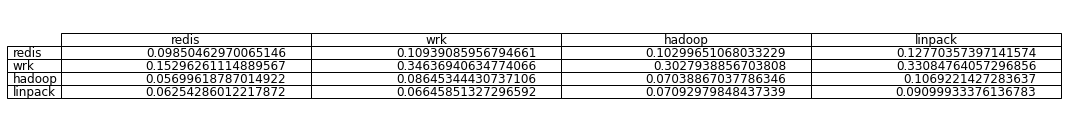

In [24]:
fig, ax = plt.subplots()
fig.patch.set_visible(False)
fig.set_size_inches((15, 2))
ax.axis("off")
ax.axis("tight")

def_size = plt.rcParams["font.size"]
plt.rcParams.update({"font.size": 12.})
print(def_size)


df = pd.DataFrame(inference, columns=tasks)
ax.table(cellText=df.values, colLabels=df.columns,rowLabels=tasks, loc="center")
fig.tight_layout()
plt.show()